In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('04-stock_price_prediction.csv')
df.head()

,Unnamed: 0,Stock_1,Stock_2,Stock_3,Stock_4,Stock_5
0,2020-01-01,101.764052,100.160928,99.494642,99.909756,101.761266
1,2020-01-02,102.171269,99.969968,98.682973,100.640755,102.528643
2,2020-01-03,103.171258,99.575237,98.182139,100.574847,101.887811
3,2020-01-04,105.483215,99.308641,97.149381,100.925017,101.490049
4,2020-01-05,107.453175,98.188428,99.575396,101.594411,101.604283


In [ ]:
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'],dayfirst=False)
df.set_index('Date', inplace=True)

In [4]:
df.head()

,Stock_1,Stock_2,Stock_3,Stock_4,Stock_5
Date,,,,,
2020-01-01,101.764052,100.160928,99.494642,99.909756,101.761266
2020-01-02,102.171269,99.969968,98.682973,100.640755,102.528643
2020-01-03,103.171258,99.575237,98.182139,100.574847,101.887811
2020-01-04,105.483215,99.308641,97.149381,100.925017,101.490049
2020-01-05,107.453175,98.188428,99.575396,101.594411,101.604283


In [ ]:
series= df['Stock_1'].values
print(series[:10])

[101.76405235 102.17126854 103.17125755 105.48321524 107.45317546
 106.40305934 107.41398249 107.25140368 107.14070001 107.58061812]


In [6]:
class StockDataset(Dataset):
    def __init__(self, data, seq_length=10):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length]
        y = self.data[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [ ]:
class StockLSTMWithState(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=3, output_size=1, dropout_prob=0.2):
        super(StockLSTMWithState, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                              batch_first=True, 
                              dropout=dropout_prob if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        # x shape: (batch_size, 1, input_size) for single step
        # or (batch_size, seq_len, input_size) for initial steps
        
        # if no hidden state is provided, initialize it to zeros
        if hidden is None:
            # (num_layers, batch_size, hidden_size)
            h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            hidden = (h_0, c_0)
            
        # LSTM returns output and the new hidden state
        out, hidden = self.lstm(x, hidden)
        
        # cpnnect the last time step's output to the fully connected layer
        out = self.fc(out)
        
        return out, hidden

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.reshape(-1, 1)).flatten()

In [ ]:
import random
import numpy as np

seq_length = 30
dataset = StockDataset(series_scaled, seq_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# hyperparameters
model = StockLSTMWithState() # new model
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
num_epochs = 200
teacher_forcing_ratio_start = 1.0
teacher_forcing_ratio_end = 0.1
teacher_forcing_decay_epochs = 150 # decay over these many epochs

# --- training loop with Scheduled Sampling ---
for epoch in range(num_epochs):
    # linear decay
    epsilon = np.interp(epoch, [0, teacher_forcing_decay_epochs], [teacher_forcing_ratio_start, teacher_forcing_ratio_end])

    for x_batch, y_batch in dataloader:
        # x_batch shape: (batch_size, seq_len)
        # y_batch shape: (batch_size,)
        
        x_batch = x_batch.unsqueeze(-1) # -> (batch_size, seq_len, 1)
        y_batch = y_batch.unsqueeze(-1) # -> (batch_size, 1)
        
        optimizer.zero_grad()
        
        batch_size = x_batch.size(0)
        seq_len = x_batch.size(1)
        
        # store all outputs
        outputs = torch.zeros(batch_size, seq_len, 1).to(x_batch.device)
        # initialize
        hidden = None
        # first input to the model is the first time step
        current_input = x_batch[:, 0, :].unsqueeze(1) # (batch_size, 1, 1)

        # iterate over the sequence
        for t in range(seq_len):
            # predict the next value
            output, hidden = model(current_input, hidden)
            
            # store the output
            outputs[:, t, :] = output.squeeze(1)
            
            # --- Scheduled Sampling  ---
            use_teacher_forcing = random.random() < epsilon
            
            if use_teacher_forcing:
                # the next input is the actual next value from the sequence
                current_input = x_batch[:, t+1, :].unsqueeze(1) if t < seq_len - 1 else output
            else:
                # use the model's own prediction as the next input
                current_input = output

        # --- calculate loss ---
        # only the final output is used for loss calculation
        # because we want to predict the next value after the entire sequence
        final_output = outputs[:, -1, :]
        loss = criterion(final_output, y_batch)
        
        loss.backward()
        optimizer.step()
        
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}, Epsilon: {epsilon:.4f}')

Epoch [5/200], Loss: 0.204424, Epsilon: 0.9760
Epoch [10/200], Loss: 0.023204, Epsilon: 0.9460
Epoch [15/200], Loss: 0.048516, Epsilon: 0.9160
Epoch [20/200], Loss: 0.005760, Epsilon: 0.8860
Epoch [25/200], Loss: 0.008813, Epsilon: 0.8560
Epoch [30/200], Loss: 0.004835, Epsilon: 0.8260
Epoch [35/200], Loss: 0.004887, Epsilon: 0.7960
Epoch [40/200], Loss: 0.011822, Epsilon: 0.7660
Epoch [45/200], Loss: 0.004834, Epsilon: 0.7360
Epoch [50/200], Loss: 0.021068, Epsilon: 0.7060
Epoch [55/200], Loss: 0.002195, Epsilon: 0.6760
Epoch [60/200], Loss: 0.013935, Epsilon: 0.6460
Epoch [65/200], Loss: 0.004348, Epsilon: 0.6160
Epoch [70/200], Loss: 0.002713, Epsilon: 0.5860
Epoch [75/200], Loss: 0.004925, Epsilon: 0.5560
Epoch [80/200], Loss: 0.011024, Epsilon: 0.5260
Epoch [85/200], Loss: 0.005382, Epsilon: 0.4960
Epoch [90/200], Loss: 0.003150, Epsilon: 0.4660
Epoch [95/200], Loss: 0.004634, Epsilon: 0.4360
Epoch [100/200], Loss: 0.003344, Epsilon: 0.4060
Epoch [105/200], Loss: 0.019641, Epsilon

In [10]:
model.eval()
test_inputs = torch.tensor(series_scaled[-seq_length:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)  # (1, seq_length, 1)

test_inputs.shape

torch.Size([1, 30, 1])

In [11]:
preds = []
hidden_state = None
current_input = None

# 从你最后的真实数据中获取启动序列和隐藏状态
# last_real_sequence 的 shape: (1, seq_len, 1)
last_real_sequence = test_inputs[:, -seq_length:, :]  # (1, seq_length, 1)

with torch.no_grad():
    # --- 初始化步骤 ---
    # 首先，将整个真实序列喂给模型，以获得“热启动”的隐藏状态
    # 并且得到第一个预测值
    pred_out, hidden_state = model(last_real_sequence, None)
    
    # 第一个预测值是基于真实序列的最后一个点得到的
    first_pred = pred_out[:, -1, :] # shape: (1, 1)
    preds.append(first_pred.item())
    print(f'Predicted: {first_pred.item()}')
    
    # 将第一个预测值作为下一步的输入
    current_input = first_pred.unsqueeze(1) # (1, 1) -> (1, 1, 1)

# --- 自回归循环 (预测剩下的 49 步) ---
for _ in range(49):  
    with torch.no_grad():
        # 模型现在只需要接收上一步的输出和隐藏状态
        # 输入的序列长度是 1
        pred_out, hidden_state = model(current_input, hidden_state)
        
        # pred_out 的 shape 是 (1, 1, 1)
        final_pred = pred_out.squeeze(1) # (1, 1, 1) -> (1, 1)
        
        preds.append(final_pred.item())
        print(f'Predicted: {final_pred.item()}')
        
        # 更新 current_input 为当前预测值，为下一步做准备
        current_input = pred_out # pred_out 已经是 (1, 1, 1) 的正确形状

Predicted: 0.2021140456199646
Predicted: 0.2284826934337616
Predicted: 0.26432743668556213
Predicted: 0.30302906036376953
Predicted: 0.33980125188827515
Predicted: 0.372402161359787
Predicted: 0.40014922618865967
Predicted: 0.4230496883392334
Predicted: 0.44139033555984497
Predicted: 0.45559340715408325
Predicted: 0.46615496277809143
Predicted: 0.47359970211982727
Predicted: 0.4784463047981262
Predicted: 0.48118531703948975
Predicted: 0.482265830039978
Predicted: 0.48208802938461304
Predicted: 0.48099833726882935
Predicted: 0.4792884588241577
Predicted: 0.47719696164131165
Predicted: 0.47491276264190674
Predicted: 0.47258055210113525
Predicted: 0.4703068137168884
Predicted: 0.46816593408584595
Predicted: 0.46620607376098633
Predicted: 0.464454710483551
Predicted: 0.4629232585430145
Predicted: 0.46161121129989624
Predicted: 0.4605095088481903
Predicted: 0.4596031904220581
Predicted: 0.45887380838394165
Predicted: 0.45830100774765015
Predicted: 0.4578639268875122
Predicted: 0.45754212141

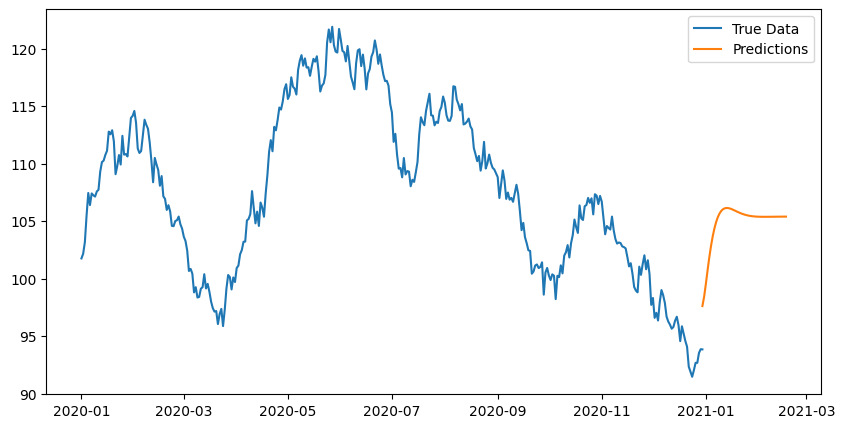

In [12]:
# 反归一化到原始价格
preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

plt.figure(figsize=(10,5))
plt.plot(df.index, series, label="True Data")
plt.plot(pd.date_range(df.index[-1], periods=50, freq="D"), preds, label="Predictions")
plt.legend()
plt.show()